In [1]:
from simulation import run_simulation
import numpy as np
from policies import *
from environment import Servers
import sys

In [2]:

# Initialize basic variables
num_requests = 15#int(input("num_requests: "))
num_servers = 4#int(input("num_servers: "))
num_trajectories_list = [0] + [10 ** i for i in range(1, 7)]
start_trajectory_index = 0
num_boot = 5
# end_trajectory_index = 1

# Initialize policies
behavior_policy = ('UniRan', UniRan(num_servers))
target_policy1 = ('LeastLoad_0.3', LeastLoad(num_servers, epsilon=0.3))
target_policy2 = ('LeastLoad_0', LeastLoad(num_servers, epsilon=0))
target_policy3 = ('EpsilonGreedy', EpsilonGreedy(num_servers, epsilon=0.3))
target_policy4 = ('UCB1', UCB1(num_servers))

# behavior_policy = ('EpsilonGreedy', EpsilonGreedy(num_servers, epsilon=0.3))
# target_policy1 = ('LeastLoad_0.3', LeastLoad(num_servers, epsilon=0.3))
# target_policy2 = ('LeastLoad_0', LeastLoad(num_servers, epsilon=0))
# target_policy3 = ('UniRan', UniRan(num_servers))
# target_policy4 = ('UCB1', UCB1(num_servers))


target_policies = [target_policy1, target_policy2, target_policy3, target_policy4]
num_target_policies = len(target_policies)

policies = [target_policy1, target_policy2, target_policy3, target_policy4, behavior_policy]
num_policies = 1 + num_target_policies

target_policy_names = [policy[0] for policy in policies if policy != policies[-1]]

# Initialize environment (servers)
servers = Servers(num_policies=num_policies, num_servers=num_servers)


In [3]:
import pickle

In [5]:
trace_lst = []
latency_lst = []
for _ in range(5*10**5):
    total_latency_for_each_policy, trace = \
                run_simulation(policies=policies, num_requests=num_requests, servers=servers)
    trace_lst.append(trace)
    latency_lst.append(total_latency_for_each_policy)
    if _ % 100000 == 99999:
        print(_, ' complete')
with open('trace1.p', 'wb') as fp:
    pickle.dump(trace_lst, fp)           
with open('latency1.p', 'wb') as fp:
    pickle.dump(latency_lst, fp)  


99999  complete
199999  complete
299999  complete
399999  complete
499999  complete


In [4]:
trace_lst = []
latency_lst = []
for _ in range(5*10**5):
    total_latency_for_each_policy, trace = \
                run_simulation(policies=policies, num_requests=num_requests, servers=servers)
    trace_lst.append(trace)
    latency_lst.append(total_latency_for_each_policy)
    if _ % 100000 == 99999:
        print(_, ' complete')
with open('trace2.p', 'wb') as fp:
    pickle.dump(trace_lst, fp)           
with open('latency2.p', 'wb') as fp:
    pickle.dump(latency_lst, fp)  


99999  complete
199999  complete
299999  complete
399999  complete
499999  complete


In [4]:
trace=pickle.load(open('trace1.p', 'rb'))

In [5]:
pol_rho1 = [np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests)),
           np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests))]
pol_r1 = [np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests)),
           np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests))]
for i in range(len(trace)):
    for k in range(len(target_policies)):
        target_policies[k][1].reset()
    if i%500000 == 499999:
        print(i, ' complete')
    for j in range(num_requests):
        state, action, r, old_p = trace[i][j]
        server_load, lst_rewards = state
        for k in range(len(target_policies)):
            for a_, r_ in lst_rewards:
                target_policies[k][1].update(a_, r_)
            new_p = target_policies[k][1].choose_action(context=server_load, return_prob=True)
            if j == 0:
                pol_rho1[k][i,j] = new_p[action]/old_p[action]
            else:
                pol_rho1[k][i,j] = new_p[action]/old_p[action]*pol_rho1[k][i, j-1]
            pol_r1[k][i,j] = r

499999  complete


In [6]:
trace = None

In [7]:
trace=pickle.load(open('trace2.p', 'rb'))

In [8]:
pol_rho2 = [np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests)),
           np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests))]
pol_r2 = [np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests)),
           np.zeros((len(trace), num_requests)), np.zeros((len(trace), num_requests))]
for i in range(len(trace)):
    for k in range(len(target_policies)):
        target_policies[k][1].reset()
    if i%50000 == 49999:
        print(i, ' complete')
    for j in range(num_requests):
        state, action, r, old_p = trace[i][j]
        server_load, lst_rewards = state
        for k in range(len(target_policies)):
            for a_, r_ in lst_rewards:
                target_policies[k][1].update(a_, r_)
            new_p = target_policies[k][1].choose_action(context=server_load, return_prob=True,
                                                        behavior_policy=False, chosen_action=action)
            if j == 0:
                pol_rho2[k][i,j] = new_p[action]/old_p[action]
            else:
                pol_rho2[k][i,j] = new_p[action]/old_p[action]*pol_rho2[k][i, j-1]
            pol_r2[k][i,j] = r

49999  complete
99999  complete
149999  complete
199999  complete
249999  complete
299999  complete
349999  complete
399999  complete
449999  complete
499999  complete


In [9]:
trace = None

In [13]:
pol_rho = np.concatenate((pol_rho1, pol_rho2), axis=1)
pol_r = np.concatenate((pol_r1, pol_r2), axis=1)

In [15]:
with open('pol_rho.p', 'wb') as fp:
    pickle.dump(pol_rho, fp)           
with open('pol_r.p', 'wb') as fp:
    pickle.dump(pol_r, fp)

In [16]:
pol_rho=pickle.load(open('pol_rho.p', 'rb'))
pol_r=pickle.load(open('pol_r.p', 'rb'))

In [17]:
def get_estimates(pol_rho, pol_r, n_samples):
    D = n_samples
    estimates = []
    for i in range(4):
        rhos = pol_rho[i][:D]
        rs = pol_r[i][:D]
        IS = np.sum(rhos[:,-1]*np.sum(rs, axis=1)/D)
        SIS = np.sum(np.sum(rhos*rs/D, axis=1))
        ws = np.sum(rhos, axis=0)
        WIS = np.sum(rhos[:,-1]/ws[-1]*np.sum(rs, axis=1))
        SWIS = np.sum(np.sum(rhos/ws*rs, axis=1))
        estimates.append((IS, SIS, WIS, SWIS))
    return estimates

In [18]:
estimates = []
for i in range(1, 7):
  estimates.append(get_estimates(pol_rho, pol_r, 10**i))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [35]:
boot_estimates = [estimates]
for i in range(100):
  if i % 20 == 19:
    print(i+1, ' complete')
  boot_ind = np.random.choice(range(10**6), 10**6)
  boot_rho = pol_rho[:, boot_ind, :]
  boot_r = pol_r[:, boot_ind, :]
  estimates = []
  for i in range(1, 7):
    estimates.append(get_estimates(boot_rho, boot_r, 10**i))
  boot_estimates.append(np.array(estimates))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


20  complete
40  complete
60  complete
80  complete
100  complete


In [36]:
boot_estimates = np.array(boot_estimates)

In [21]:
latency1=pickle.load(open('latency1.p', 'rb'))
latency2=pickle.load(open('latency2.p', 'rb'))

In [25]:
latency = np.concatenate((latency1, latency2), axis=0)

In [27]:
true_val = latency.mean(axis=0)[:4]

In [29]:
import matplotlib.pyplot as plt

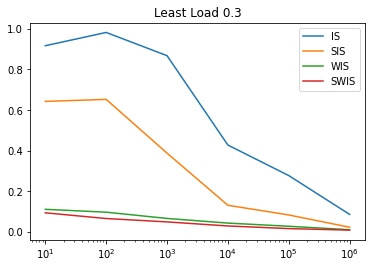

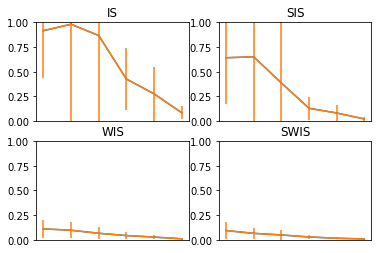

In [37]:
a = true_val[0]
x = [10**i for i in range(1,7)]
for i in range(4): 
  error = np.abs((a - boot_estimates[:,:,0,i])/a)
  plt.plot(x, np.mean(error, axis=0))
plt.xscale('log')
plt.legend(['IS', 'SIS', 'WIS', 'SWIS'])
plt.title('Least Load 0.3')
plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axs = [ax1, ax2, ax3, ax4]
titles = ['IS', 'SIS', 'WIS', 'SWIS']
for i in range(4): 
  error = np.abs((a - boot_estimates[:,:,0,i])/a)
  axs[i].plot(x, np.mean(error, axis=0))
  axs[i].errorbar(x, np.mean(error, axis=0), np.std(error, axis=0))
  axs[i].set_xscale('log')
  axs[i].title.set_text(titles[i])
  axs[i].set_ylim(0,1)
  axs[i].set_xticks([])
fig.show()

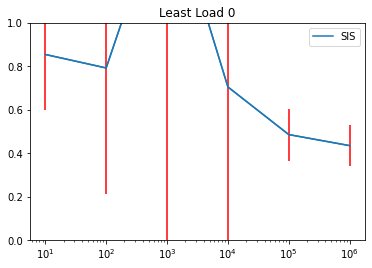

In [39]:
a = true_val[1]
for i in [1]: 
  error = np.abs((a - boot_estimates[:,:,1,i])/a)
  plt.plot(x, np.mean(error, axis=0))
  plt.errorbar(x, np.mean(error, axis=0), np.std(error, axis=0), ecolor='r')
plt.xscale('log')
plt.ylim(0,1)
plt.legend(['SIS'])
plt.title('Least Load 0')
plt.show()

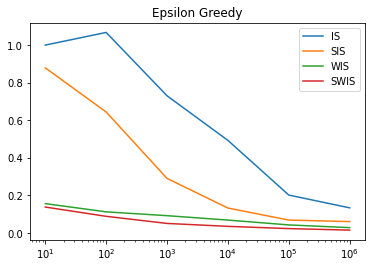

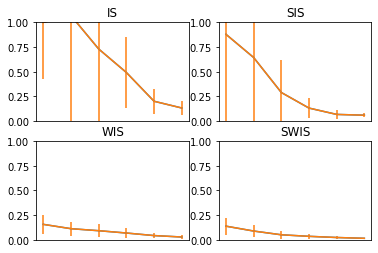

In [41]:
a = true_val[2]
for i in range(4): 
  error = np.abs((a - boot_estimates[:,:,2,i])/a)
  plt.plot(x, np.mean(error, axis=0))
plt.xscale('log')
plt.legend(['IS', 'SIS', 'WIS', 'SWIS'])
plt.title('Epsilon Greedy')
plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axs = [ax1, ax2, ax3, ax4]
titles = ['IS', 'SIS', 'WIS', 'SWIS']
for i in range(4): 
  error = np.abs((a - boot_estimates[:,:,2,i])/a)
  axs[i].plot(x, np.mean(error, axis=0))
  axs[i].errorbar(x, np.mean(error, axis=0), np.std(error, axis=0))
  axs[i].set_xscale('log')
  axs[i].title.set_text(titles[i])
  axs[i].set_ylim(0,1)
  axs[i].set_xticks([])
fig.show()

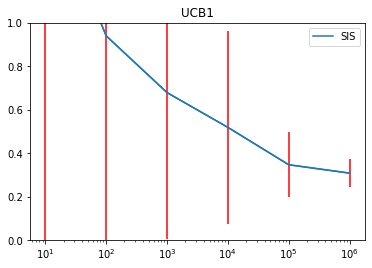

In [42]:
a = true_val[3]
for i in [1]: 
  error = np.abs((a - boot_estimates[:,:,3,i])/a)
  plt.plot(x, np.mean(error, axis=0))
  plt.errorbar(x, np.mean(error, axis=0), np.std(error, axis=0), ecolor='r')
plt.xscale('log')
plt.ylim((0, 1))
plt.legend(['SIS'])
plt.title('UCB1')
plt.show()